In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_excel('/content/drive/MyDrive/cleaned_shipment_dataset.xlsx')
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,order_id,supplier_id,supplier_rating,supplier_lead_time,order_date,promised_delivery_date,actual_delivery_date,shipment_mode,shipping_distance_km,order_quantity,unit_price,total_order_value,weather_condition,region,holiday_period,previous_on_time_rate,carrier_name,delayed_reason_code,on_time_delivery
0,1.0,5322.0,3.4,10,1715731200000000000,1716595200000000000,1716940800000000000,Sea,51,48,2153.91,103387.68,Clear,East,No,89.9,EcomExpress,Operational,0.0
1,2.0,3932.0,4.3,10,1731369600000000000,1732233600000000000,1732665600000000000,Sea,373,91,405.36,36887.76,Rainy,East,Yes,93.6,DHL,Customs,0.0
2,3.0,8966.0,3.2,5,1724803200000000000,1725235200000000000,1725235200000000000,Sea,1304,25,3241.41,81035.25,Cloudy,South,No,78.2,BlueDart,Customs,1.0
3,4.0,9832.0,3.9,7,1723420800000000000,1724025600000000000,1724025600000000000,Air,839,71,365.79,25971.09,Rainy,Central,No,85.2,FedEx,Operational,1.0
4,5.0,2126.0,3.2,8,1720310400000000000,1721001600000000000,1721260800000000000,Sea,258,9,3052.84,27475.56,Cloudy,East,No,77.1,BlueDart,Customs,0.0


In [3]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10019 entries, 0 to 10018
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                10019 non-null  float64
 1   supplier_id             10019 non-null  float64
 2   supplier_rating         10019 non-null  float64
 3   supplier_lead_time      10019 non-null  int64  
 4   order_date              10019 non-null  int64  
 5   promised_delivery_date  10019 non-null  int64  
 6   actual_delivery_date    10019 non-null  int64  
 7   shipment_mode           10019 non-null  object 
 8   shipping_distance_km    10019 non-null  int64  
 9   order_quantity          10019 non-null  int64  
 10  unit_price              10019 non-null  float64
 11  total_order_value       10019 non-null  float64
 12  weather_condition       10019 non-null  object 
 13  region                  10019 non-null  object 
 14  holiday_period          10019 non-null

,0
order_id,0
supplier_id,0
supplier_rating,0
supplier_lead_time,0
order_date,0
promised_delivery_date,0
actual_delivery_date,0
shipment_mode,0
shipping_distance_km,0
order_quantity,0


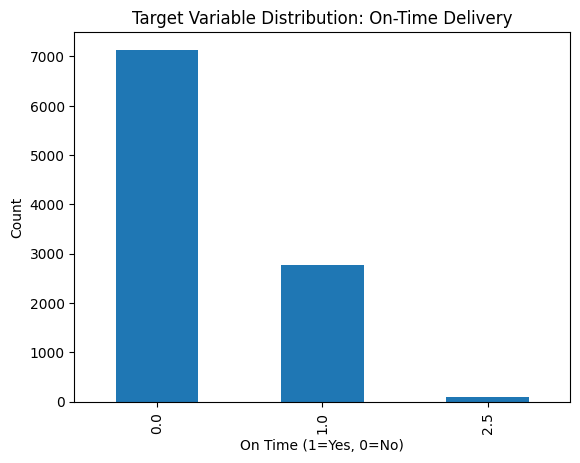

In [4]:
df['on_time_delivery'].value_counts().plot(kind='bar')
plt.title("Target Variable Distribution: On-Time Delivery")
plt.xlabel("On Time (1=Yes, 0=No)")
plt.ylabel("Count")
plt.show()


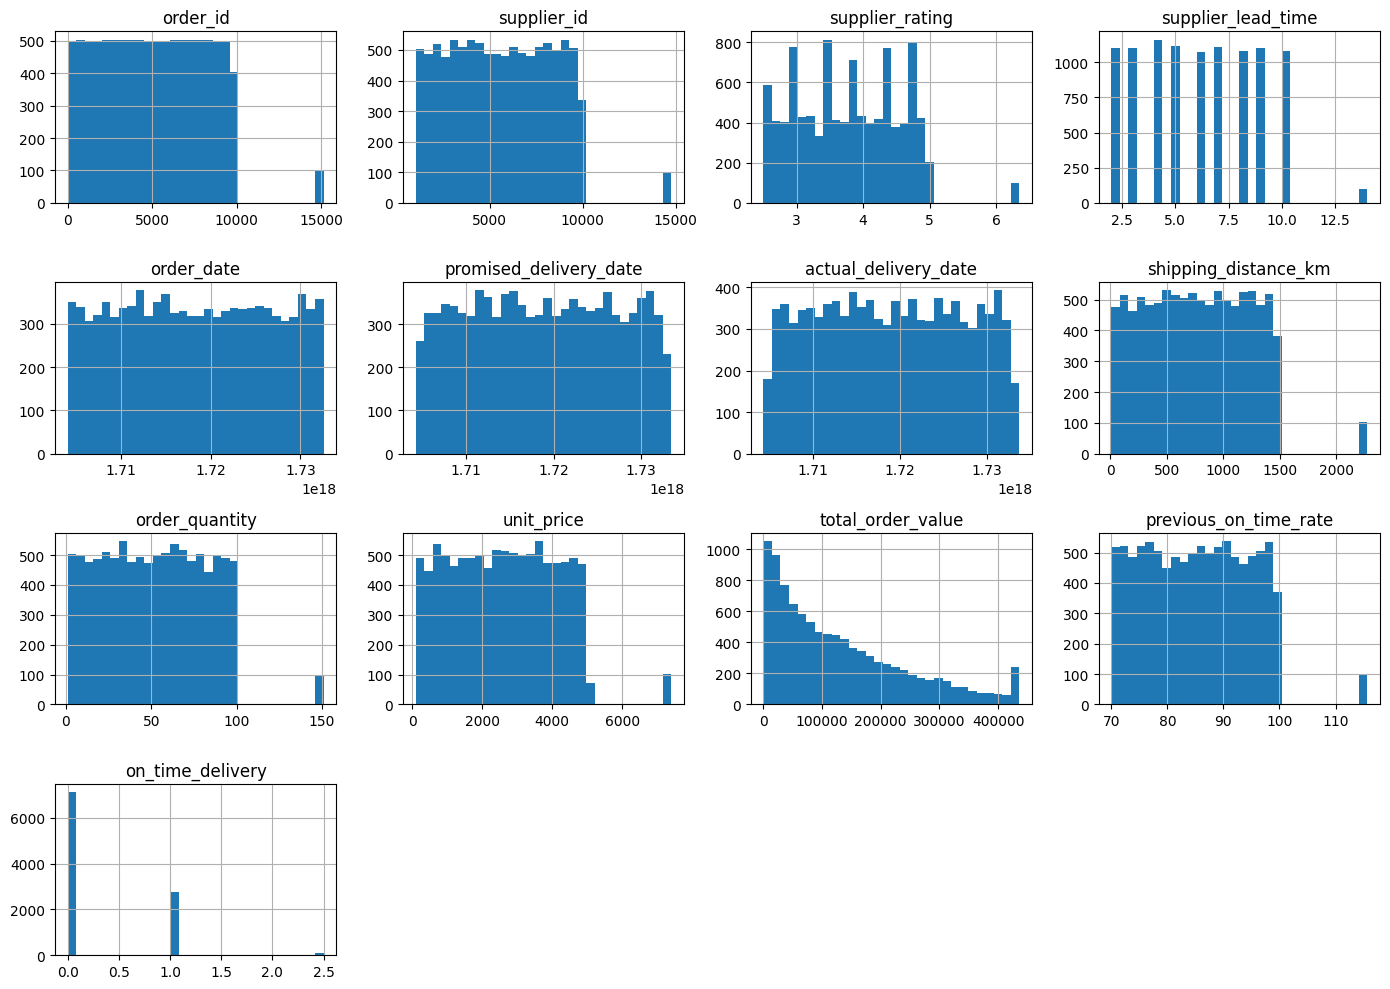

In [5]:
df.hist(bins=30, figsize=(14, 10))
plt.tight_layout()
plt.show()


In [10]:
# Convert date columns to datetime
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['actual_delivery_date'] = pd.to_datetime(df['actual_delivery_date'], errors='coerce')
df['promised_delivery_date'] = pd.to_datetime(df['promised_delivery_date'], errors='coerce')

# Create delivery_days
df['delivery_days'] = (df['actual_delivery_date'] - df['order_date']).dt.days

df[['order_date','actual_delivery_date','delivery_days']].head()


,order_date,actual_delivery_date,delivery_days
0,2024-05-15,2024-05-29,14
1,2024-11-12,2024-11-27,15
2,2024-08-28,2024-09-02,5
3,2024-08-12,2024-08-19,7
4,2024-07-07,2024-07-18,11


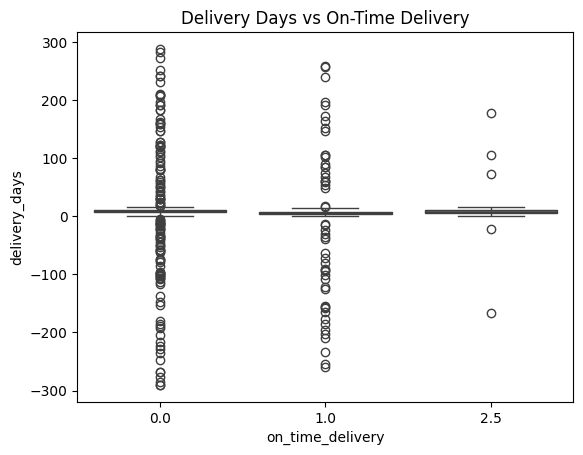

In [11]:
sns.boxplot(x=df['on_time_delivery'], y=df['delivery_days'])
plt.title("Delivery Days vs On-Time Delivery")
plt.show()


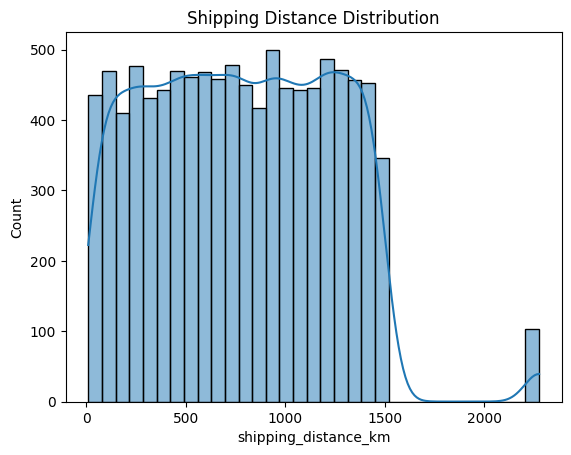

In [12]:
sns.histplot(df['shipping_distance_km'], kde=True)
plt.title("Shipping Distance Distribution")
plt.show()


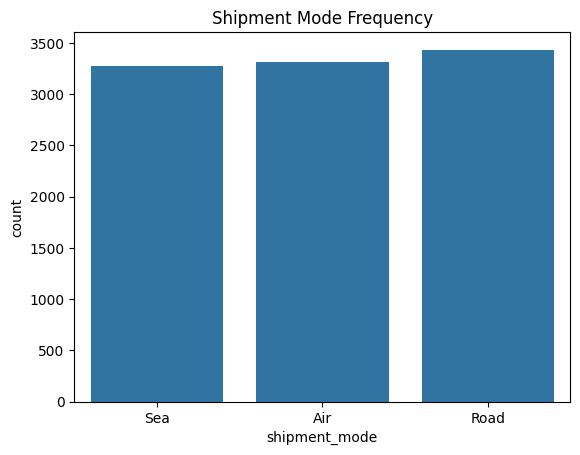

In [13]:
sns.countplot(x=df['shipment_mode'])
plt.title("Shipment Mode Frequency")
plt.show()


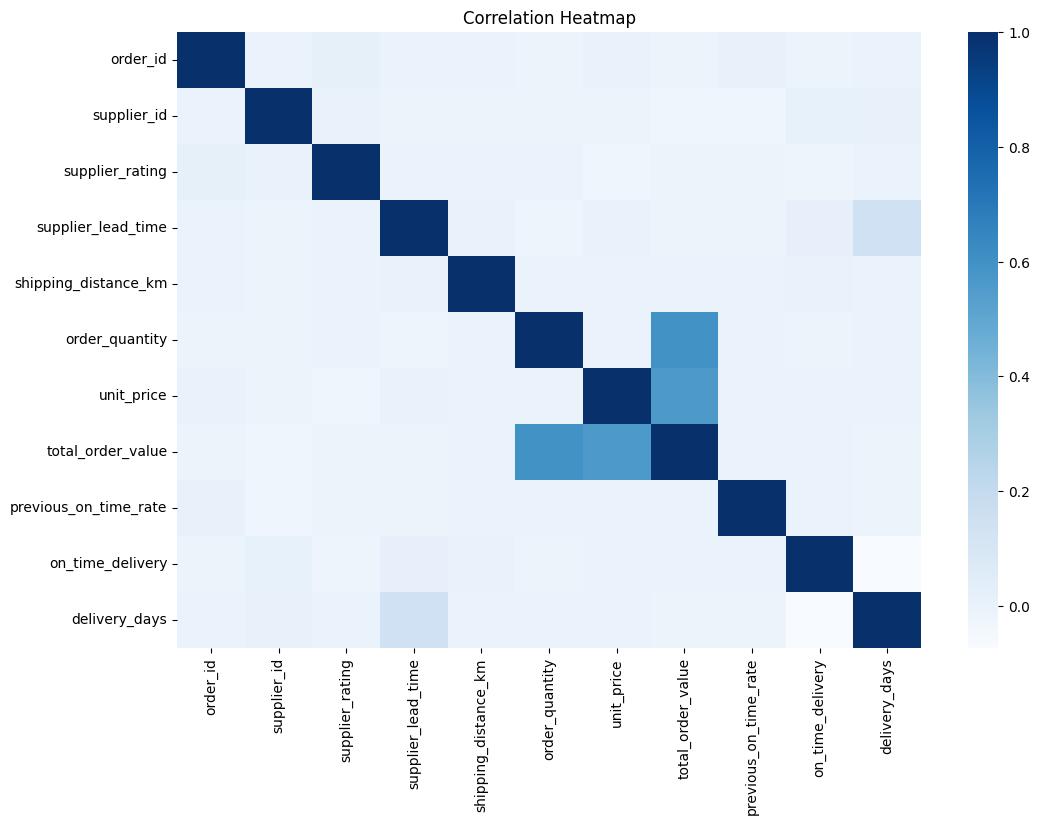

In [15]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=False, cmap="Blues")
plt.title("Correlation Heatmap")
plt.show()


In [16]:
target = 'on_time_delivery'
X = df.drop(target, axis=1)
y = df[target]


In [17]:
X = pd.get_dummies(X, drop_first=True)


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

num_cols = ['delivery_days', 'order_quantity', 'shipping_distance_km']
X[num_cols] = scaler.fit_transform(X[num_cols])


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [20]:
df['delivery_speed'] = pd.cut(
    df['delivery_days'],
    bins=[-1, 2, 5, 10, 100],
    labels=['Fast','Normal','Slow','Very_Slow']
)

df = pd.get_dummies(df, columns=['delivery_speed'], drop_first=True)


In [21]:
df['long_distance'] = (df['shipping_distance_km'] > 700).astype(int)


In [22]:
df['high_rating'] = (df['supplier_rating'] >= 4).astype(int)


In [23]:
df_encoded = pd.get_dummies(df, drop_first=True)


In [25]:
df_encoded.to_excel("processed_milestone2_dataset.xlsx", index=False)
print("Processed file saved successfully!")


Processed file saved successfully!
